In [1]:
from keras import Model
from keras.engine.topology import Layer
from keras.layers import Dense,Flatten,Input,Conv2D,MaxPool2D
from keras.layers import Activation,LeakyReLU,ReLU
from keras.layers.normalization import BatchNormalization
import struct
import numpy as np
import cv2
import matplotlib.pyplot as plt

Using TensorFlow backend.


In [28]:
model_cfg = 'yolov3-tiny.cfg'

weights_path = 'yolov3-tiny.weights'
net_h, net_w = 416, 416
obj_thresh, nms_thresh = 0.5, 0.45
anchors = [[116,90,  156,198,  373,326],  [30,61, 62,45,  59,119], [10,13,  16,30,  33,23]]
labels = ["person", "bicycle", "car", "motorbike", "aeroplane", "bus", "train", "truck", \
          "boat", "traffic light", "fire hydrant", "stop sign", "parking meter", "bench", \
          "bird", "cat", "dog", "horse", "sheep", "cow", "elephant", "bear", "zebra", "giraffe", \
          "backpack", "umbrella", "handbag", "tie", "suitcase", "frisbee", "skis", "snowboard", \
          "sports ball", "kite", "baseball bat", "baseball glove", "skateboard", "surfboard", \
          "tennis racket", "bottle", "wine glass", "cup", "fork", "knife", "spoon", "bowl", "banana", \
          "apple", "sandwich", "orange", "broccoli", "carrot", "hot dog", "pizza", "donut", "cake", \
          "chair", "sofa", "pottedplant", "bed", "diningtable", "toilet", "tvmonitor", "laptop", "mouse", \
          "remote", "keyboard", "cell phone", "microwave", "oven", "toaster", "sink", "refrigerator", \
          "book", "clock", "vase", "scissors", "teddy bear", "hair drier", "toothbrush"]

In [5]:
def parse_cfg(cfg_path):
    cfg_file = open(cfg_path,'r')
    lines = cfg_file.read().split('\n')
    
    lines = [x for x in lines if x != '']
    lines = [x for x in lines if x[0] != '#']
    
    layers = []
    layer = {}
    
    for line in lines:
        if line[0] == '[':
            if len(layers) != 0 or layer != {}:
                layers.append(layer)
                layer = {}
            layer['type'] = line.replace('[','').replace(']','')
        else:
            key,value = line.split('=')
            layer[key] = value
    layers.append(layer)
    return layers

In [26]:
class YoloLayer(Layer):
    def __init__(self,):
        super(YoloLayer,self).__init__()
    
    def build(self,input_shape):
        super(YoloLayer,self).build(input_shape)
    
    def call(self,x):
        # input_shape = (None,13,13,255)
        
        
        return x
    
    def compute_output_shape(self,input_shape):
        return input_shape
    

In [13]:
def create_model(layers_dict):
    model = Model()
    
    model_info = {}
    
    for layer_dict in layers_dict:
        if layer_dict['type'] == 'net':
            model_info = layer_dict
            height, width, channels = (int(model_info['height']), int(model_info['width']), int(model_info['channels']))
            input_layer = Input(( height, width, channels ))
            x = input_layer
        elif layer_dict['type'] == 'convolutional':
            filters = int(layer_dict['filters'])
            kernel_size = (int(layer_dict['size']), int(layer_dict['size']))
            padding = 'same' if layer_dict['pad'] == '1' else 'valid'
            stride = (int(layer_dict['stride']), int(layer_dict['stride']))
            
            activation = layer_dict['activation']
            
            x = Conv2D(filters = filters, kernel_size = kernel_size, padding = padding, strides = stride)(x)
            
            try:
                batch_norm = int(layer_dict['batch_normalize'])
                if batch_norm:
                    x = BatchNormalization()(x)
            except:
                pass
            
            if activation == 'leaky':
                x = LeakyReLU(0.1)(x)
            elif activation == 'linear':
                x = Activation(activation='linear')(x)
        elif layer_dict['type'] == 'maxpool':
            size = ( int(layer_dict['size']), int(layer_dict['size']) )
            stride = int(layer_dict['stride'])
            padding = 'same' if stride == 1 else 'valid'
    
            x = MaxPool2D(size,strides=stride,padding=padding)(x)
        elif layer_dict['type'] == 'yolo':
            x = YoloLayer()(x)
            break
            
    model = Model(inputs=input_layer,outputs = x)
    return model

In [27]:
model = create_model(parse_cfg(model_cfg))

Yolo (None, 13, 13, 255)


In [23]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         (None, 416, 416, 3)       0         
_________________________________________________________________
conv2d_27 (Conv2D)           (None, 416, 416, 16)      448       
_________________________________________________________________
batch_normalization_25 (Batc (None, 416, 416, 16)      64        
_________________________________________________________________
leaky_re_lu_25 (LeakyReLU)   (None, 416, 416, 16)      0         
_________________________________________________________________
max_pooling2d_19 (MaxPooling (None, 208, 208, 16)      0         
_________________________________________________________________
conv2d_28 (Conv2D)           (None, 208, 208, 32)      4640      
_________________________________________________________________
batch_normalization_26 (Batc (None, 208, 208, 32)      128       
__________

In [19]:
class WeightReader:
    def __init__(self, weight_file):
#         with open(weight_file, 'rb') as w_f:
#             major,    = struct.unpack('i', w_f.read(4))
#             minor,    = struct.unpack('i', w_f.read(4))
#             revision, = struct.unpack('i', w_f.read(4))

#             if (major*10 + minor) >= 2 and major < 1000 and minor < 1000:
#                 w_f.read(8)
#             else:
#                 w_f.read(4)

#             transpose = (major > 1000) or (minor > 1000)
            
#             binary = w_f.read()


        fp = open(weight_file,'r')
        major = np.fromfile(fp,dtype=np.int32,count=5)
        
        self.offset = 0
#         self.all_weights = np.frombuffer(binary, dtype='float32')
        self.all_weights = np.fromfile(fp,dtype=np.float32)
    def read_bytes(self, size):
        self.offset = self.offset + size
        return self.all_weights[self.offset-size:self.offset]

    def load_weights(self, model):
        for layer in model.layers:
            name = layer.name
            print('load weight to {}'.format(name))
            name, *_ = name.split('_')
            
            if name == 'conv2d':
                if len(layer.get_weights()) > 1:
                    kernel = self.read_bytes(np.prod(layer.get_weights()[0].shape))
                    bias = self.read_bytes(np.prod(layer.get_weights()[1].shape))
                    
                    kernel = kernel.reshape(list(reversed(layer.get_weights()[0].shape)))
                    kernel = kernel.transpose([2,3,1,0])
                    layer.set_weights([kernel, bias])
                else:
                    kernel = self.read_bytes(np.prod(layer.get_weights()[0].shape))
                    kernel = kernel.reshape(list(reversed(layer.get_weights()[0].shape)))
                    kernel = kernel.transpose([2,3,1,0])
                    layer.set_weights([kernel])
            elif name == 'batch':
                    size = np.prod(layer.get_weights()[0].shape)

                    beta  = self.read_bytes(size) # bias
                    gamma = self.read_bytes(size) # scale
                    mean  = self.read_bytes(size) # mean
                    var   = self.read_bytes(size) # variance            

                    layer.set_weights([gamma, beta, mean, var])  
    
    def reset(self):
        self.offset = 0

In [43]:
weight_reader = WeightReader(weights_path)
weight_reader.load_weights(model)

load weight to input_6
load weight to conv2d_24
load weight to batch_normalization_23
load weight to leaky_re_lu_23
load weight to max_pooling2d_18
load weight to conv2d_25
load weight to batch_normalization_24
load weight to leaky_re_lu_24
load weight to max_pooling2d_19
load weight to conv2d_26
load weight to batch_normalization_25
load weight to leaky_re_lu_25
load weight to max_pooling2d_20


In [19]:
def preprocess_img(img,net_width,net_height):
    img_h,img_w = img.shape[:2]

    if img_h > img_w:
        new_h = int(net_height)
        new_w = int(img_w * net_height / img_h)
    else:
        new_w = int(net_width)
        new_h = int(img_h * net_width / img_w)
    img = img[:,:,::-1]
    img = img/255.
    resized = cv2.resize(img,(new_w,new_h))
    base_img = np.ones((net_height,net_width,3)) * 0.5
    base_img[(net_height-new_h)//2 : (net_height+new_h)//2,(net_width-new_w)//2 : (net_width+new_w)//2,:] = resized
    base_img = np.expand_dims(base_img,0)
    return base_img

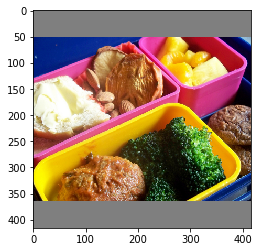

In [25]:
img = cv2.imread('testimg.jpg')
pre_img = preprocess_img(img,416,416)
plt.imshow(pre_img[0])

In [29]:
x = model.predict(pre_img)

In [30]:
x

array([[[[ 5.01921924e-04,  4.82847588e-03, -2.58594519e-03, ...,
          -3.71411152e-04,  2.23480561e-03,  1.10620102e-04],
         [ 9.06037109e-04,  5.43470588e-03,  8.91179370e-04, ...,
           8.23250681e-04, -1.05127180e-03, -9.95438662e-04],
         [ 9.02361935e-04,  6.34514447e-03,  2.43660971e-03, ...,
          -4.18311683e-05, -1.90119271e-03, -1.43138622e-03],
         ...,
         [-1.20764971e-03,  9.58956499e-03,  6.05435157e-03, ...,
          -2.18447740e-03, -1.74626498e-03, -2.45394208e-03],
         [-4.01887635e-04,  7.66421109e-03,  5.45614492e-03, ...,
          -4.00845078e-04, -6.66582840e-04, -3.03180912e-03],
         [-6.36299141e-04,  9.82927624e-03,  4.77544265e-03, ...,
          -4.99405223e-06, -2.96824379e-03, -1.70653209e-03]],

        [[-1.46802282e-03,  4.11575427e-03, -2.44906894e-03, ...,
          -3.79321212e-03,  1.06825745e-02,  1.30941265e-03],
         [-5.87074028e-04,  2.77297036e-03,  1.84859708e-03, ...,
          -9.03771911e

In [37]:
fp = open(weights_path,'r')


In [38]:
major = np.fromfile(fp,dtype=np.int32,count=5)
w = np.fromfile(fp,dtype=np.float32)

In [39]:
major

array([       0,        2,        0, 32013312,        0], dtype=int32)

In [41]:
w.shape

(8858734,)

3.0